# Deep Learning for tensiometry of pendant drop

### Import necessary packages and self-defined classes

In [6]:
# pyplot
import matplotlib.pyplot as plt
# pytorch
import torch
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
#Test/Train data split
from functools import lru_cache
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import logging
# sklearn
from sklearn import preprocessing
# os
import os
# warnings
import warnings
warnings.filterwarnings('ignore')
# random
import random
# math
import math

# self-defined model
from model_pic import *
from model_cal import *
import pandas as pd

#PictureNet
from PIL import Image
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Dataset loading and preprocessing

In [7]:
class DataSplit:

    def __init__(self, dataset, test_train_split=0.8, val_train_split=0.1, shuffle=False):
        self.dataset = dataset

        dataset_size = len(dataset)
        self.indices = list(range(dataset_size))
        test_split = int(np.floor(test_train_split * dataset_size))

        if shuffle:
            np.random.shuffle(self.indices)

        train_indices, self.test_indices = self.indices[:test_split], self.indices[test_split:]
        train_size = len(train_indices)
        validation_split = int(np.floor((1 - val_train_split) * train_size))

        self.train_indices, self.val_indices = train_indices[:validation_split], train_indices[validation_split:]

        self.train_sampler = SubsetRandomSampler(self.train_indices)
        self.val_sampler = SubsetRandomSampler(self.val_indices)
        self.test_sampler = SubsetRandomSampler(self.test_indices)
    
    def get_train_split_point(self):
        return len(self.train_sampler) + len(self.val_indices)

    def get_validation_split_point(self):
        return len(self.train_sampler)

    @lru_cache(maxsize=4)
    def get_split(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train-validation-test dataloaders')
        self.train_loader = self.get_train_loader(batch_size=batch_size, num_workers=num_workers)
        self.val_loader = self.get_validation_loader(batch_size=batch_size, num_workers=num_workers)
        self.test_loader = self.get_test_loader(batch_size=batch_size, num_workers=num_workers)
        return self.train_loader, self.val_loader, self.test_loader

    @lru_cache(maxsize=4)
    def get_train_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing train dataloader')
        self.train_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.train_sampler, shuffle=False, num_workers=num_workers)
        return self.train_loader

    @lru_cache(maxsize=4)
    def get_validation_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing validation dataloader')
        self.val_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.val_sampler, shuffle=False, num_workers=num_workers)
        return self.val_loader

    @lru_cache(maxsize=4)
    def get_test_loader(self, batch_size=64, num_workers=0):
        logging.debug('Initializing test dataloader')
        self.test_loader = DataLoader(self.dataset, batch_size=batch_size, sampler=self.test_sampler, shuffle=False, num_workers=num_workers)
        return self.test_loader

### Load data for PhysicsNet

In [8]:
data_matrix = df = pd.DataFrame()

data_matrix = pd.read_csv("Big_Data1/Picture_Large.csv", header= None)

#print(data_matrix)


# Make the droplet dataset class based on data_matrix
class Droplet_data_set(Dataset):
    def __init__(self):
        x = data_matrix.iloc[0:,3:].values
        y = data_matrix.iloc[0:,0:2].values
        # x = np.random.normal(x,0.01)
        y0 = data_matrix.iloc[:,0].values
        y1 = data_matrix.iloc[:,1].values
        
        # Add normalization for x
        # x = preprocessing.normalize(x)
        # y = preprocessing.normalize(y, axis = 0,norm='l2')


        self.x_train = torch.tensor(x,dtype=torch.float32)
        self.y_train = torch.tensor(y,dtype=torch.float32)
        
    def __getitem__(self, idx):
        return self.x_train[idx],self.y_train[idx]
    
    def __len__(self):
         return len(self.y_train)
        
my_data_set = Droplet_data_set()

# Split the single dataset into 3 datasets for training, test and validation.
split = DataSplit(my_data_set, shuffle=True)
train_loader, val_loader, test_loader = split.get_split(batch_size=64, num_workers=0)


### Load data for PictureNet
Read image from files

In [9]:
train_img = []

data_image = pd.read_csv("Big_Data1/Picture_Large.csv", header= None)   # Large dataset
for img_name in data_image.iloc[0:,3:].index + 1:      # modify the number depends on size of dataset
    # defining the image path
    image_path = 'Big_Data1/' + str(img_name) + '.png'      # modify the path depends on which dataset
    # reading the image
    img = imread(image_path, as_gray=True)
    img = img[4:-4, 4:-4]  #crop 
    # normalizing the pixel values
    img /= 255.0
    # converting the type of pixel to float 32
    img = img.astype('float32')
    # appending the image into the list
    train_img.append(img)

Plot a single image for viewing

Current image = 4442
Picture size = (82, 77)


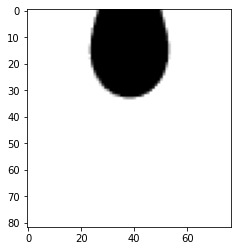

In [10]:
rand = random.randint(0, 53084)
print("Current image =", rand)
print("Picture size =", train_img[rand].shape)
plt.imshow(train_img[rand], cmap='gray')

<font color=red>
Rewrite the picture tensor generation into function.<br>
For training process to resuffle the batches!!!!!
</font>

In [13]:
# converting the list to numpy array
train_x_pic = np.array(train_img)
train_y_pic = data_image.iloc[0:,3:].values            # modify the number depends on size of dataset
train_x_pic, rem_x_pic, train_y_pic, rem_y_pic = train_test_split(train_x_pic, train_y_pic, test_size = 0.2)    # default shuffle = True
val_x_pic, test_x_pic, val_y_pic, test_y_pic = train_test_split(rem_x_pic, rem_y_pic, test_size = 0.5)

# converting the trian images and targets into torch format
train_x_pic = train_x_pic.reshape(len(train_x_pic), 1, 82, 77)
train_x_pic  = torch.from_numpy(train_x_pic)
train_y_pic = torch.from_numpy(train_y_pic)
# print(train_x_pic.shape, train_y_pic.shape)

# converting the val images and targets into torch format
val_x_pic = val_x_pic.reshape(len(val_x_pic), 1, 82, 77)
val_x_pic  = torch.from_numpy(val_x_pic)
val_y_pic = torch.from_numpy(val_y_pic)
# print(val_x_pic.shape, val_y_pic.shape)

# converting the test images and targets into torch format
test_x_pic = test_x_pic.reshape(len(test_x_pic), 1, 82, 77)
test_x_pic  = torch.from_numpy(test_x_pic)
test_y_pic = torch.from_numpy(test_y_pic)
# print(test_x_pic.shape, test_y_pic.shape)

# converting the dataset into mini-batch dataset (input 4D -> 5D and 2D -> 3D)
def batch_transform(dataset, batch_size=64):
    batch = []
    batch_num = math.ceil(len(dataset)/batch_size)
    for i in range(batch_num):
        if len(dataset) == 4:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :, :, :])
            else:
                batch.append(dataset[i*batch_size:, :, :, :])
        else:
            if i < batch_num-1:
                batch.append(dataset[i*batch_size:(i+1)*batch_size, :])
            else:
                batch.append(dataset[i*batch_size:, :])
    return batch

train_x_pic = batch_transform(train_x_pic)
train_y_pic = batch_transform(train_y_pic)
val_x_pic = batch_transform(val_x_pic)
val_y_pic = batch_transform(val_y_pic)
test_x_pic = batch_transform(test_x_pic)
test_y_pic = batch_transform(test_y_pic)
print(len(train_x_pic), len(train_y_pic), len(val_x_pic), len(val_y_pic), len(test_x_pic), len(test_y_pic))

664 664 83 83 83 83


### Deside to apply host or device


In [255]:
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
#device = torch.device('cpu')
print(device)

cuda


## Define the functions

In [261]:
def loss_cal_phiysics(loss_list, model, loader):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def loss_cal_picture(loss_list, model, x_dataset, y_dataset):
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        loss_epoch = 0
        for t in range(len(x_dataset)):
            x = x_dataset[t]
            y = y_dataset[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)
            loss_epoch += loss
        loss_list.append(loss_epoch/t)

def prediction(model, x):   # only a batch
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        x = x.to(device=device, dtype=torch.float32)
        score = torch.Tensor.cpu(model(x))
    return score

def model_selection(model, path, loss, epoch_current, epoch_ref, loss_ref):
    loss_best = loss_ref
    epoch_best = epoch_ref
    if epoch_current == 0:
            loss_current = loss[epoch_current]
            loss_best = loss[epoch_current]
            torch.save(model, path)
    else:
        loss_current = loss[epoch_current]
        if loss_current <= (loss_best * 1.1):   # 10% margin to get better fitting but a bit more loss
            loss_best = loss_current
            epoch_best = epoch_current
            torch.save(model, path)
    return loss_best, epoch_best

def train_physics(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    PATH_CAL = os.path.join(os.getcwd(), "model_cal.pt")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for _, (x, y) in enumerate(train_loader):
            x = x.reshape(len(x), 1, 1, -1)     # reshape to 4D data for formal input of model
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)
            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_phiysics(loss_train, model, train_loader)
        loss_cal_phiysics(loss_val, model, val_loader)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))

        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_CAL, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())
    
    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()

def train_picture(model, optimizer, epochs=1):
    loss_train = []
    loss_val = []
    loss_best = 0
    epoch_best = 0
    PATH_PIC = os.path.join(os.getcwd(), "model_pic.pt")
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t in range(len(train_x_pic)):
            model.train()  # put model to training mode
            x = train_x_pic[t]
            y = train_y_pic[t]
            x = x.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            scores = model(x)
            loss = F.mse_loss(scores, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        loss_cal_picture(loss_train, model, train_x_pic, train_y_pic)
        loss_cal_picture(loss_val, model, val_x_pic, val_y_pic)
        print('epoch %d: train_loss = %.4f, val_loss = %.4f' % (e+1, loss_train[e], loss_val[e]))
        
        # selecting the best model to save
        loss_best, epoch_best = model_selection(model, PATH_PIC, loss_train, e, epoch_best, loss_best)
    
    print("The model is saved at epoch =", epoch_best+1, "and the loss =", loss_best.item())

    x = range(1, epochs+1)

    plt.semilogy(x, loss_train, 'b-', label="training loss")
    plt.semilogy(x, loss_val, 'r--', label="validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("MSE Loss")
    plt.title("Train/Validation Loss")
    plt.legend()
    plt.show()


## Train PhysicsNet

epoch 1: train_loss = 805.0726, val_loss = 813.1058
epoch 2: train_loss = 132.5147, val_loss = 134.9169
epoch 3: train_loss = 16.4591, val_loss = 16.1386
epoch 4: train_loss = 2.5136, val_loss = 2.4655
epoch 5: train_loss = 2.4894, val_loss = 2.4910
epoch 6: train_loss = 1.6398, val_loss = 1.6278
epoch 7: train_loss = 13.1140, val_loss = 13.1506
epoch 8: train_loss = 0.8586, val_loss = 0.8425
epoch 9: train_loss = 9.8053, val_loss = 9.9246
epoch 10: train_loss = 5.0617, val_loss = 5.1418
epoch 11: train_loss = 3.4305, val_loss = 3.4732
epoch 12: train_loss = 5.2088, val_loss = 5.2906
epoch 13: train_loss = 3.0930, val_loss = 3.1535
epoch 14: train_loss = 9.9076, val_loss = 9.7742
epoch 15: train_loss = 2.1324, val_loss = 2.1752
epoch 16: train_loss = 2.4641, val_loss = 2.4675
epoch 17: train_loss = 1.8089, val_loss = 1.8584
epoch 18: train_loss = 0.7432, val_loss = 0.7540
epoch 19: train_loss = 4.3606, val_loss = 4.2638
epoch 20: train_loss = 3.6457, val_loss = 3.6038
epoch 21: train_l

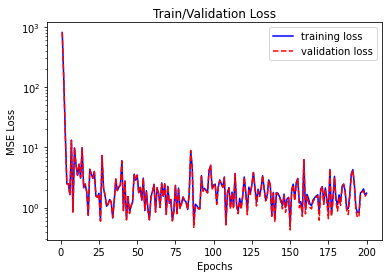

In [260]:
in_channel = 160
node_1 = 1024
node_2 = 1024
node_3 = 512
node_4 = 256
node_5 = 64
node_6 = 16
out_channel = 2

learning_rate = 1e-3

model_physics = PhysicsNet(in_channel, node_1, node_2, node_3, node_4, node_5, node_6, out_channel)
optimizer = optim.Adam(model_physics.parameters(), lr=learning_rate)
epoch = 200

train_physics(model_physics, optimizer, epoch)


### Retrain with SGD
<font color=red>
To be verify the effect!!
</font>

epoch 1: train_loss = 1.2516, val_loss = 1.1676
epoch 2: train_loss = 2.0603, val_loss = 1.9840
epoch 3: train_loss = 1.7456, val_loss = 1.6805
epoch 4: train_loss = 1.3275, val_loss = 1.2742
epoch 5: train_loss = 1.4718, val_loss = 1.3973
epoch 6: train_loss = 1.8269, val_loss = 1.7414
epoch 7: train_loss = 2.1763, val_loss = 2.1009
epoch 8: train_loss = 2.0320, val_loss = 1.9694
epoch 9: train_loss = 0.9214, val_loss = 0.8487
epoch 10: train_loss = 1.0861, val_loss = 1.0143
epoch 11: train_loss = 1.5902, val_loss = 1.5210
epoch 12: train_loss = 1.3247, val_loss = 1.2586
epoch 13: train_loss = 1.4773, val_loss = 1.4264
epoch 14: train_loss = 1.8512, val_loss = 1.7720
epoch 15: train_loss = 2.0613, val_loss = 1.9736
epoch 16: train_loss = 1.5136, val_loss = 1.4429
epoch 17: train_loss = 0.7093, val_loss = 0.6357
epoch 18: train_loss = 1.6743, val_loss = 1.5795
epoch 19: train_loss = 1.3101, val_loss = 1.2444
epoch 20: train_loss = 1.4122, val_loss = 1.3634
epoch 21: train_loss = 1.7474

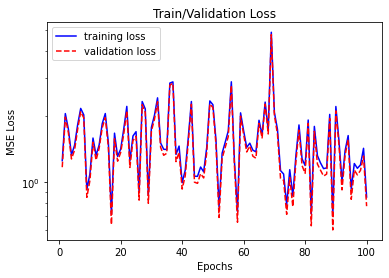

In [263]:
# PATH_CAL = os.path.join(os.getcwd(), "model_cal.pt")
# model_physics_trained = torch.load(PATH_CAL)

# learning_rate = 1e-4

# optimizer = optim.SGD(model_physics_trained.parameters(), lr=learning_rate)
# epoch = 100

# train_physics(model_physics_trained, optimizer, epoch)

### Visualization of outcomes

In [264]:
PATH_CAL = os.path.join(os.getcwd(), "model_cal.pt")
model_physics_trained = torch.load(PATH_CAL)

examples = enumerate(test_loader)
_, (x_test_example, y_test_example) = next(examples)

score_example = prediction(model_physics_trained, x_test_example)
# y = data_matrix.iloc[0:,0:2].values
#Revert normalized values back to real values
# Print only 8 data samples for comparison
print("Ground Truths =", y_test_example[:15])
print("Prediction    =", score_example[:15].reshape(15, 2))

Ground Truths = tensor([[40.9000, 14.3000],
        [61.4000, 25.6000],
        [46.7000, 21.2000],
        [75.9000, 33.5000],
        [40.0000, 14.1000],
        [80.2000, 37.4000],
        [51.3000, 14.3000],
        [75.6000, 26.6000],
        [39.3000, 17.6000],
        [41.9000, 13.9000],
        [79.2000, 35.3000],
        [64.5000, 19.4000],
        [79.2000, 22.4000],
        [61.0000, 25.4000],
        [70.9000, 30.0000]])
Prediction    = tensor([[40.2993, 14.1021],
        [61.0548, 25.5014],
        [46.6851, 20.9570],
        [74.6320, 32.7109],
        [39.5169, 13.9283],
        [78.1141, 36.4838],
        [50.4016, 14.3765],
        [73.9426, 26.5294],
        [38.7867, 17.1173],
        [41.3679, 13.8634],
        [77.5994, 34.3926],
        [63.4021, 19.3466],
        [76.9993, 22.1931],
        [60.5725, 25.2973],
        [69.9739, 29.4501]])


## Train PictureNet

<font color=red> 
The more we train (higher epoch), the more model learns to make points connect smoother. However, the loss becomes larger.<br>
Apply early stopping and save the best model? 
</font>

epoch 1: train_loss = 0.0056, val_loss = 0.0056
epoch 2: train_loss = 0.1970, val_loss = 0.1984
epoch 3: train_loss = 0.0073, val_loss = 0.0073
epoch 4: train_loss = 0.0643, val_loss = 0.0646
epoch 5: train_loss = 0.2611, val_loss = 0.2630
epoch 6: train_loss = 4.0143, val_loss = 4.0621
epoch 7: train_loss = 0.9204, val_loss = 0.9319
epoch 8: train_loss = 0.0050, val_loss = 0.0050
epoch 9: train_loss = 0.0633, val_loss = 0.0647
epoch 10: train_loss = 0.0990, val_loss = 0.1021
epoch 11: train_loss = 0.0802, val_loss = 0.0800
epoch 12: train_loss = 0.1396, val_loss = 0.1418
epoch 13: train_loss = 0.0251, val_loss = 0.0249
epoch 14: train_loss = 0.1789, val_loss = 0.1801
epoch 15: train_loss = 0.0566, val_loss = 0.0568
epoch 16: train_loss = 0.0609, val_loss = 0.0620
epoch 17: train_loss = 0.0955, val_loss = 0.0957
epoch 18: train_loss = 2.1170, val_loss = 2.1367
epoch 19: train_loss = 0.1841, val_loss = 0.1857
epoch 20: train_loss = 0.0216, val_loss = 0.0218
epoch 21: train_loss = 0.1902

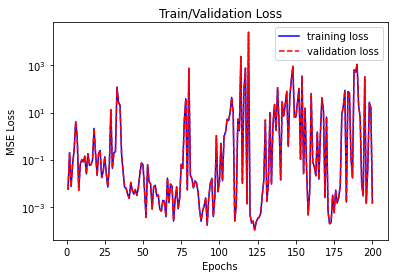

In [265]:
in_channel = 1
channel_1 = 16
channel_2 = 32
channel_3 = 64
node_1 = 1024
node_2 = 1024
out_channel = 160

learning_rate = 1e-3

model_picture = PictureNet(in_channel, channel_1, channel_2, channel_3, node_1, node_2, out_channel)
optimizer = optim.Adam(model_picture.parameters(), lr=learning_rate)
epoch = 200

train_picture(model_picture, optimizer, epoch)

### Visualization of outcomes

In [266]:
# testing cell for better viewing the length
train_x_pic, train_y_pic

print(len(train_x_pic))
print(train_x_pic[0].shape)
print(train_y_pic[0].shape)

664
torch.Size([64, 1, 82, 77])
torch.Size([64, 160])


In [267]:
PATH_PIC = os.path.join(os.getcwd(), "model_pic.pt")
model_picture_trained = torch.load(PATH_PIC)

rand1 = random.randint(0, len(test_x_pic)-1)
rand2 = random.randint(0, 63)

print("current batch =", rand1)
print("current testing image =", rand2)

score_pic = prediction(model_picture_trained, test_x_pic[rand1][rand2].reshape(1, 1, 82, 77))
for num in range(len(test_y_pic[rand1][rand2])):
    print(num+1, ": Ground Truths =", test_y_pic[rand1][rand2][num].item(), ", Prediction =", score_pic[0, num].item())


current batch = 62
current testing image = 52
1 : Ground Truths = -9.350142271408401e-24 , Prediction = -0.004812141880393028
2 : Ground Truths = 0.0654126136184959 , Prediction = 0.05954752117395401
3 : Ground Truths = 0.130683597452681 , Prediction = 0.12657655775547028
4 : Ground Truths = 0.195681065873257 , Prediction = 0.19899868965148926
5 : Ground Truths = 0.26026026882043 , Prediction = 0.26134029030799866
6 : Ground Truths = 0.324268948761571 , Prediction = 0.31762760877609253
7 : Ground Truths = 0.38762561123647 , Prediction = 0.38027024269104004
8 : Ground Truths = 0.450145889737677 , Prediction = 0.4455878734588623
9 : Ground Truths = 0.511716374388502 , Prediction = 0.5024239420890808
10 : Ground Truths = 0.572257736746543 , Prediction = 0.5616998672485352
11 : Ground Truths = 0.63157810399202 , Prediction = 0.6270952224731445
12 : Ground Truths = 0.689641857665835 , Prediction = 0.6839160919189453
13 : Ground Truths = 0.746310293412917 , Prediction = 0.7399237751960754
14

### Plot the ground truth and prediction to make a comparison

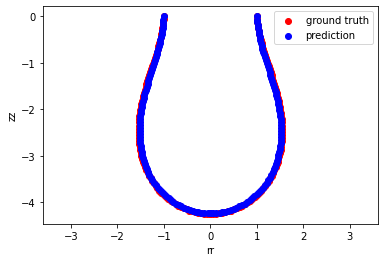

In [268]:
# scattering points for ground truth
x_gt_pos = test_y_pic[rand1][rand2][0:80]
y_gt_pos = test_y_pic[rand1][rand2][80:160]
x_gt_neg = -torch.flip(x_gt_pos, [0])
y_gt_neg = torch.flip(y_gt_pos, [0])
x_gt = torch.cat((x_gt_neg, x_gt_pos))
y_gt = torch.cat((y_gt_neg, y_gt_pos))

# scattering points for prediction
x_pred_pos = score_pic[0, 0:80]
y_pred_pos = score_pic[0, 80:160]
x_pred_neg = -torch.flip(x_pred_pos, [0])
y_pred_neg = torch.flip(y_pred_pos, [0])
x_pred = torch.cat((x_pred_neg, x_pred_pos))
y_pred = torch.cat((y_pred_neg, y_pred_pos))

plt.scatter(x_gt, y_gt, c="red", label="ground truth")
plt.scatter(x_pred, y_pred, c="blue", label="prediction")
plt.xlabel("rr")
plt.ylabel("zz")
plt.legend()
plt.axis('equal')
plt.show()